# Image Classification Mini Project

#### You can get the dataset from https://www.kaggle.com/greysky/pencil-dataset

In [ ]:
import os, glob
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import torch
from torch import nn
from torch import optim
from torch.utils.data import Dataset, DataLoader
import albumentations as A

In [ ]:
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
NUM_EPOCHS = 15
BATCH_SIZE = 8

### CNN Architecture

In [ ]:
class Net(nn.Module):
  def __init__(self):
    super().__init__()
    self.model = nn.Sequential(
        nn.Conv2d(3, 8, 5, 4, 2),      # (n, 3, 128, 128) => (n, 8, 32, 32)
        nn.ReLU(),
        nn.MaxPool2d(2, 2),            # (n, 8, 32, 32) => (n, 8, 16, 16)
        nn.Conv2d(8, 16, 3, 1, 1),     # (n, 8, 16, 16) => (n, 16, 16, 16)
        nn.ReLU(),
        nn.MaxPool2d(2, 2),            # (n, 16, 16, 16) => (n, 16, 8, 8)
        nn.Flatten(),                  # (n, 16, 8, 8) => (n, 1024)
        nn.Linear(1024, 128),          # (n, 1024) => (n, 128)
        nn.ReLU(),
        nn.Linear(128, 2))             # (n, 128) => (n, 2)

  def forward(self, x):
    return self.model(x)

### Custom Dataset

In [ ]:
class PencilDataset(Dataset):
  def __init__(self, root, transform=None):
    super().__init__()
    self.root = root
    self.classes = ["red_pencil", "green_pencil"]
    self.img_paths = glob.glob(f"{root}/red*.jpg") +  glob.glob(f"{root}/green*.jpg")
    self.transform = transform

  def __len__(self):
    return len(self.img_paths)

  def __getitem__(self, idx):
    img_path = self.img_paths[idx]
    image = Image.open(img_path)
    target = 0 if "red" in img_path else 1

    if self.transform:
      augmented = self.transform(image=np.array(image))
      image = torch.from_numpy(augmented['image'])
      image = image.permute(2, 0, 1)
      image = image / 255.0
      
    return image, target

### Plot Function

In [ ]:
def plot_images(loader, n_samples):
  data_iter = iter(loader)
  
  imgs, targets = next(iter(loader))
  fig, axes = plt.subplots(1, n_samples, figsize=(20, 6))

  for img, target, ax in zip(imgs, targets, axes):
    ax.set_title(loader.dataset.classes[target])
    ax.axis("off")
    ax.imshow(img.permute(1, 2, 0))

### Transforms

In [ ]:
train_transform = A.Compose([
    A.CenterCrop(height=800, width=800),
    A.RandomRotate90(p=1.0),
    A.Resize(height=128, width=128),
])

valid_transform = A.Compose([
    A.CenterCrop(height=800, width=800),
    A.Resize(height=128, width=128),
])

test_transform = A.Compose([
    A.CenterCrop(height=800, width=800),
    A.Resize(height=128, width=128),
])

### Dataset Initialization

In [ ]:
train_set = PencilDataset('dataset/train', transform=train_transform)
train_loader = DataLoader(train_set, batch_size=BATCH_SIZE, shuffle=True)

valid_set = PencilDataset('dataset/valid', transform=valid_transform)
valid_loader = DataLoader(valid_set, batch_size=BATCH_SIZE, shuffle=True)

test_set = PencilDataset('dataset/test', transform=test_transform)
test_loader = DataLoader(test_set, batch_size=BATCH_SIZE, shuffle=True)

### Train Samples

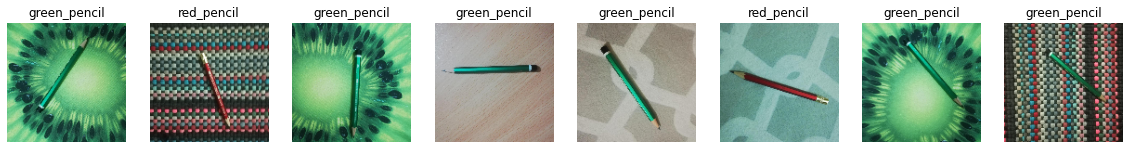

In [ ]:
plot_images(train_loader, 8)

### Valid Samples

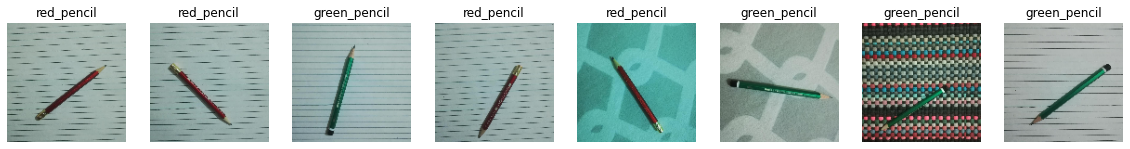

In [ ]:
plot_images(valid_loader, 8)

### Test Samples

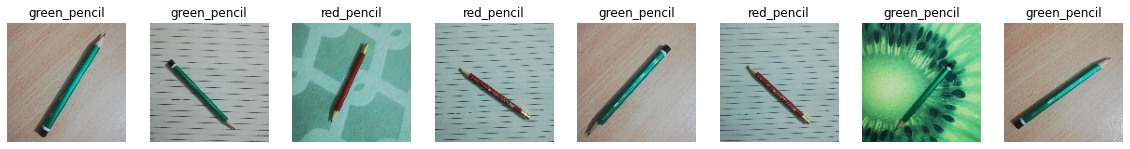

In [ ]:
plot_images(test_loader, 8)

### Model Initialization

In [ ]:
model = Net().to(DEVICE)
optimizer = optim.Adam(model.parameters())
criterion = nn.CrossEntropyLoss()

### Train Function

In [ ]:
def train_fn(loader, model, optimizer, loss_fn):
  total_loss = 0.0
  model.train()

  for batch_idx, (x, y) in enumerate(loader):
    x, y = x.to(DEVICE), y.to(DEVICE)

    pred_y = model(x)
    loss = loss_fn(pred_y, y)
    total_loss += loss.item()

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

  return (total_loss / len(loader))

### Validation Function

In [ ]:
def valid_fn(loader, model, loss_fn):
  total_loss = 0.0
  model.eval()

  with torch.no_grad(): 
    for batch_idx, (x, y) in enumerate(loader):
      x, y = x.to(DEVICE), y.to(DEVICE)

      pred_y = model(x)
      total_loss += loss_fn(pred_y, y).item()
    
    return (total_loss / len(loader))

### Training

In [ ]:
train_y, valid_y = [], []
min_loss = 100.0

for i in range(NUM_EPOCHS):
  loss = train_fn(train_loader, model, optimizer, criterion)
  train_y.append(loss)

  vloss = valid_fn(valid_loader, model, criterion)
  valid_y.append(vloss)
  
  print('{0}.loss: {1:.4f}    vloss: {2:.4f}'.format(i + 1, loss, vloss))

  if (vloss < min_loss):
    min_loss = vloss
    torch.save(model.state_dict(), 'model.data')

1.loss: 0.7008    vloss: 0.6946
2.loss: 0.6955    vloss: 0.6929
3.loss: 0.6924    vloss: 0.6926
4.loss: 0.6915    vloss: 0.6903
5.loss: 0.6908    vloss: 0.6828
6.loss: 0.6900    vloss: 0.6818
7.loss: 0.6746    vloss: 0.6551
8.loss: 0.6395    vloss: 0.6360
9.loss: 0.5444    vloss: 0.4458
10.loss: 0.3771    vloss: 0.3005
11.loss: 0.1893    vloss: 0.2359
12.loss: 0.1016    vloss: 0.1152
13.loss: 0.0475    vloss: 0.0862
14.loss: 0.0346    vloss: 0.0998
15.loss: 0.0298    vloss: 0.0604


### Loss Graph

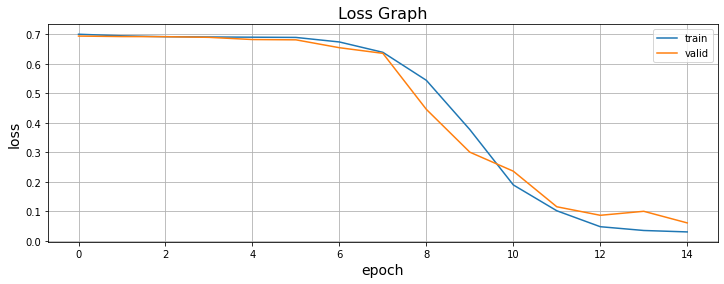

In [ ]:
plt.rcParams["figure.figsize"] = (12, 4)

plt.title('Loss Graph', fontsize=16)
plt.xlabel('epoch', fontsize=14)
plt.ylabel('loss', fontsize=14)

plt.plot(train_y)
plt.plot(valid_y)
plt.legend(['train', 'valid'])
plt.grid()

plt.show()

### Plot Functions

In [ ]:
def plot_predictions(loader, model, n_samples):
  data_iter = iter(loader)
  
  imgs, targets = next(iter(loader))

  model.eval()
  with torch.no_grad():
    preds = model(imgs.to(DEVICE)).argmax(axis=1).to('cpu')

  fig, axes = plt.subplots(1, n_samples, figsize=(20, 6))

  for img, pred, ax in zip(imgs, preds, axes):
    ax.set_title(loader.dataset.classes[pred])
    ax.axis("off")
    ax.imshow(img.permute(1, 2, 0))

In [ ]:
def plot_confusion_matrix(loader, model):
  cmat = [[0, 0], [0, 0]]
  model.eval()
  with torch.no_grad():
    for x, y in loader:
      y_pred = model(x).argmax(1)
      for i in range(loader.batch_size):
        cmat[y[i]][y_pred[i]] += 1

  n_total = len(loader) * loader.batch_size
  cmat[0][0] = cmat[0][0] / n_total
  cmat[0][1] = cmat[0][1] / n_total
  cmat[1][0] = cmat[1][0] / n_total
  cmat[1][1] = cmat[1][1] / n_total
      
  plt.figure(figsize = (4, 4))
  plt.matshow(cmat, fignum=1, cmap=plt.cm.copper)

  plt.xticks([0, 1], ["red", 'green'], rotation='vertical', fontsize=14)
  plt.yticks([0, 1], ["red", "green"], rotation='horizontal', fontsize=14)

  plt.xlabel('predictions', fontsize=16)
  plt.ylabel('targets', fontsize=16)

  for i in range(2):
    for j in range(2):
      plt.text(i, j, f'{cmat[j][i]:0.4f}', color='white', horizontalalignment='center')
  plt.show()

### Testing

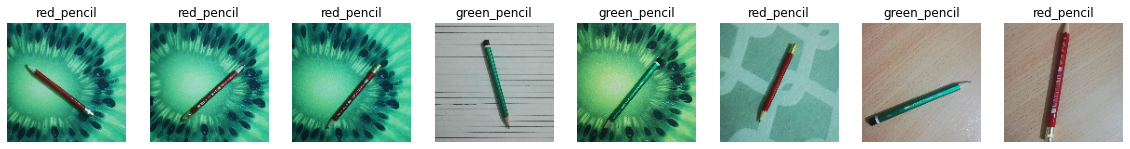

In [ ]:
plot_predictions(test_loader, model, 8)

### Confusion Matrix

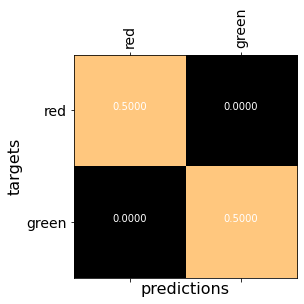

In [ ]:
plot_confusion_matrix(test_loader, model)